# Pendulum

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0
    \end{bmatrix}
\end{equation*}
$$

**Note**: To deal with angle wrap-around issues, we augment the state as follows:

$$
\begin{equation*}
\hat{\textbf{x}} = \begin{bmatrix}
    \dot{\theta} & \sin{\theta} & \cos{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by instead fitting
for unconstrained actions and then applying it to a squashing function $\tanh(\textbf{u})$.
This is directly embedded into the dynamics model in order to be auto-differentiated.
This also means that we need to apply this transformation manually to the output of our
controller at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.05  # Time step (s).
RENDER = True  # Whether to render the environment or not.
CONSTRAIN = True  # Whether to constrain the action space or not.
MIN_BOUNDS = -1.0  # Minimum torque (N m).
MAX_BOUNDS = +1.0  # Maximum torque (N m).
N = 150 if CONSTRAIN else 50  # Horizon length.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.utils.encoding.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.pendulum.PendulumCost()
model = pddp.examples.pendulum.PendulumDynamicsModel(DT)
env = pddp.examples.pendulum.PendulumEnv(dt=DT, render=RENDER)

In [8]:
if CONSTRAIN:
    # Constrain the environment and model.
    pddp.utils.constraint.constrain_env(env, MIN_BOUNDS, MAX_BOUNDS)
    pddp.utils.constraint.constrain_model(model, MIN_BOUNDS, MAX_BOUNDS)

In [9]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.angular.reduce_state(Z, model.angular_indices,
                                        model.non_angular_indices)
    X = X.detach().numpy()
    if CONSTRAIN:
        U = pddp.utils.constraint.constrain(U, MIN_BOUNDS, MAX_BOUNDS)
    U = U.detach().numpy()

    theta = np.unwrap(X[:, 0])  # Makes for smoother plots.
    theta_dot = X[:, 1]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Torque (N m)")
    plt.title("Constrained action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [10]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = pddp.utils.angular.reduce_state(Z[-1], model.angular_indices,
                                                  model.non_angular_indices).detach().numpy()
    print("iteration", iteration + 1, info, J_opt, final_state)

In [11]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [12]:
U = torch.randn(N, model.action_size, requires_grad=True)

In [13]:
J_hist = []
controller.eval()
env.reset()
Z, U = controller.fit(U, encoding=ENCODING, n_iterations=200, on_iteration=on_iteration)

iteration 1 accepted 56850.074 [ 1.6556791 -3.7024662]
iteration 2 accepted 51777.004 [0.24328366 0.3664405 ]
iteration 3 accepted 51698.46 [-0.00481678 -0.5635198 ]
iteration 4 FAILED 51698.46 [-0.00481678 -0.5635198 ]
iteration 5 FAILED 51698.46 [-0.00481678 -0.5635198 ]
iteration 6 FAILED 51698.46 [-0.00481678 -0.5635198 ]
iteration 7 FAILED 51698.46 [-0.00481678 -0.5635198 ]
iteration 8 accepted 51450.04 [-0.7443477 -2.7603045]
iteration 9 accepted 50752.54 [-1.9450898  5.0946817]
iteration 10 accepted 50250.254 [-2.0404377  5.130378 ]
iteration 11 accepted 41282.082 [-0.5205882 -2.782428 ]
iteration 12 FAILED 41282.082 [-0.5205882 -2.782428 ]
iteration 13 FAILED 41282.082 [-0.5205882 -2.782428 ]
iteration 14 FAILED 41282.082 [-0.5205882 -2.782428 ]
iteration 15 FAILED 41282.082 [-0.5205882 -2.782428 ]
iteration 16 accepted 41003.387 [0.65534353 1.6478578 ]
iteration 17 FAILED 41003.383 [0.65534353 1.6478578 ]
iteration 18 FAILED 41003.383 [0.65534353 1.6478578 ]
iteration 19 FAILE

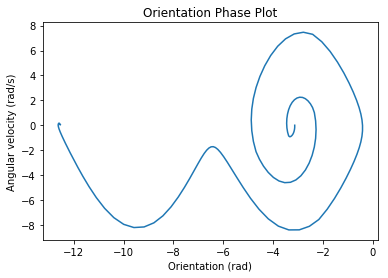

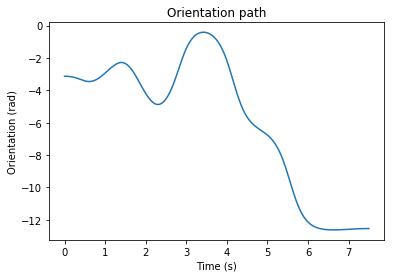

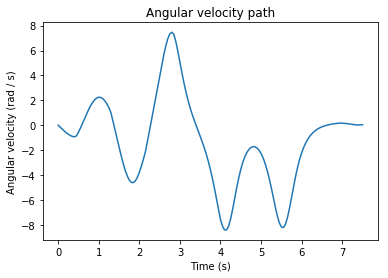

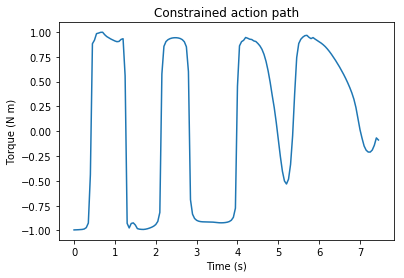

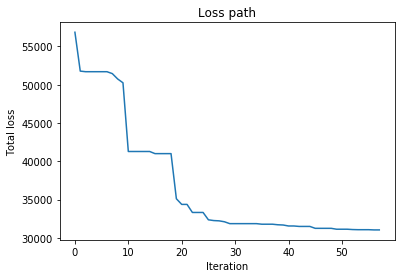

In [14]:
plot(Z, U)

In [15]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [16]:
import time

for i, u in enumerate(U):
    env.apply(u)
    time.sleep(DT)

In [17]:
env.close()